In [1]:
import zipfile
import os
zip_path = "/content/UCI_HAR_Dataset[1].zip"
extract_path = "/content/data"
os.makedirs(extract_path, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print("Unzipping complete! Files are extracted to:", extract_path)


Unzipping complete! Files are extracted to: /content/data


In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import os

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
def load_signals(folder, dataset='train'):
    signals = []
    signal_files = [f"total_acc_x_{dataset}.txt", f"total_acc_y_{dataset}.txt", f"total_acc_z_{dataset}.txt",
                    f"body_acc_x_{dataset}.txt", f"body_acc_y_{dataset}.txt", f"body_acc_z_{dataset}.txt",
                    f"body_gyro_x_{dataset}.txt", f"body_gyro_y_{dataset}.txt", f"body_gyro_z_{dataset}.txt"]

    for file in signal_files:
        filepath = os.path.join(folder, "Inertial Signals", file)
        signal = np.loadtxt(filepath).reshape(-1, 128, 1)
        signals.append(signal)

    return np.concatenate(signals, axis=-1)

Using device: cuda


In [4]:
def load_labels(filepath):
    return np.loadtxt(filepath, dtype=int).reshape(-1, 1)
train_folder = "/content/data/UCI HAR Dataset/train"
test_folder = "/content/data/UCI HAR Dataset/test"

In [5]:
train_signals = load_signals(train_folder, dataset='train')
test_signals = load_signals(test_folder, dataset='test')
train_labels = load_labels(os.path.join(train_folder, "y_train.txt"))
test_labels = load_labels(os.path.join(test_folder, "y_test.txt"))
scaler = StandardScaler()
train_signals = scaler.fit_transform(train_signals.reshape(-1, 9)).reshape(-1, 128, 9)
test_signals = scaler.transform(test_signals.reshape(-1, 9)).reshape(-1, 128, 9)

In [6]:
encoder = LabelEncoder()
train_labels = encoder.fit_transform(train_labels.ravel())
test_labels = encoder.transform(test_labels.ravel())
X_train_tensor = torch.tensor(train_signals, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(test_signals, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(train_labels, dtype=torch.long).to(device)
y_test_tensor = torch.tensor(test_labels, dtype=torch.long).to(device)

In [7]:
def create_dataloader(X, y, batch_size=32, shuffle=True):
    dataset = data.TensorDataset(X, y)
    return data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
train_loader = create_dataloader(X_train_tensor, y_train_tensor)
test_loader = create_dataloader(X_test_tensor, y_test_tensor, shuffle=False)

In [8]:
#  creating LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_dim=9, hidden_dim=64, num_layers=2, num_classes=6):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out

In [9]:
# creating 1D CNN Model
class CNN1DModel(nn.Module):
    def __init__(self, input_dim=9, num_classes=6):
        super(CNN1DModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_dim, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(32, 64, 3, stride=1, padding=1)
        self.pool = nn.MaxPool1d(2)
        self.fc = nn.Linear(64 * 32, num_classes)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.shape[0], -1)
        return self.fc(x)

In [10]:
def train_model(model, train_loader, test_loader, epochs=200, lr=0.001):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

    return model

In [11]:
lstm_model = LSTMModel()
lstm_model = train_model(lstm_model, train_loader, test_loader)

Epoch 1, Loss: 0.9442
Epoch 2, Loss: 0.5148
Epoch 3, Loss: 0.3948
Epoch 4, Loss: 0.2988
Epoch 5, Loss: 0.2146
Epoch 6, Loss: 0.1595
Epoch 7, Loss: 0.1261
Epoch 8, Loss: 0.1244
Epoch 9, Loss: 0.1166
Epoch 10, Loss: 0.1857
Epoch 11, Loss: 0.1917
Epoch 12, Loss: 0.1203
Epoch 13, Loss: 0.1124
Epoch 14, Loss: 0.1291
Epoch 15, Loss: 0.1192
Epoch 16, Loss: 0.1320
Epoch 17, Loss: 0.1123
Epoch 18, Loss: 0.1096
Epoch 19, Loss: 0.1105
Epoch 20, Loss: 0.1037
Epoch 21, Loss: 0.1023
Epoch 22, Loss: 0.1113
Epoch 23, Loss: 0.1034
Epoch 24, Loss: 0.1180
Epoch 25, Loss: 0.1083
Epoch 26, Loss: 0.1274
Epoch 27, Loss: 0.1223
Epoch 28, Loss: 0.1080
Epoch 29, Loss: 0.2083
Epoch 30, Loss: 0.1399
Epoch 31, Loss: 0.1155
Epoch 32, Loss: 0.1091
Epoch 33, Loss: 0.1041
Epoch 34, Loss: 0.1129
Epoch 35, Loss: 0.1245
Epoch 36, Loss: 0.1059
Epoch 37, Loss: 0.0985
Epoch 38, Loss: 0.0992
Epoch 39, Loss: 0.0965
Epoch 40, Loss: 0.1007
Epoch 41, Loss: 0.0981
Epoch 42, Loss: 0.0993
Epoch 43, Loss: 0.0957
Epoch 44, Loss: 0.09

In [12]:
cnn_model = CNN1DModel()
cnn_model = train_model(cnn_model, train_loader, test_loader)

Epoch 1, Loss: 0.4008
Epoch 2, Loss: 0.1236
Epoch 3, Loss: 0.1073
Epoch 4, Loss: 0.1011
Epoch 5, Loss: 0.0899
Epoch 6, Loss: 0.0837
Epoch 7, Loss: 0.0732
Epoch 8, Loss: 0.0688
Epoch 9, Loss: 0.0662
Epoch 10, Loss: 0.0611
Epoch 11, Loss: 0.0755
Epoch 12, Loss: 0.0578
Epoch 13, Loss: 0.0520
Epoch 14, Loss: 0.0516
Epoch 15, Loss: 0.0452
Epoch 16, Loss: 0.0434
Epoch 17, Loss: 0.0448
Epoch 18, Loss: 0.0871
Epoch 19, Loss: 0.0434
Epoch 20, Loss: 0.0367
Epoch 21, Loss: 0.0361
Epoch 22, Loss: 0.0317
Epoch 23, Loss: 0.0317
Epoch 24, Loss: 0.0321
Epoch 25, Loss: 0.0404
Epoch 26, Loss: 0.0314
Epoch 27, Loss: 0.0260
Epoch 28, Loss: 0.0258
Epoch 29, Loss: 0.0234
Epoch 30, Loss: 0.0219
Epoch 31, Loss: 0.0341
Epoch 32, Loss: 0.0287
Epoch 33, Loss: 0.0248
Epoch 34, Loss: 0.0182
Epoch 35, Loss: 0.0187
Epoch 36, Loss: 0.0158
Epoch 37, Loss: 0.0220
Epoch 38, Loss: 0.0327
Epoch 39, Loss: 0.0166
Epoch 40, Loss: 0.0145
Epoch 41, Loss: 0.0161
Epoch 42, Loss: 0.0157
Epoch 43, Loss: 0.0209
Epoch 44, Loss: 0.02

In [13]:
# defining evaluating function.
def evaluate_model(model, test_loader):
    model.eval()
    predictions, true_labels = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(y_batch.cpu().numpy())

    acc = accuracy_score(true_labels, predictions)
    print(f"Accuracy: {acc:.4f}")

    cm = confusion_matrix(true_labels, predictions)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.show()

Accuracy: 0.9145


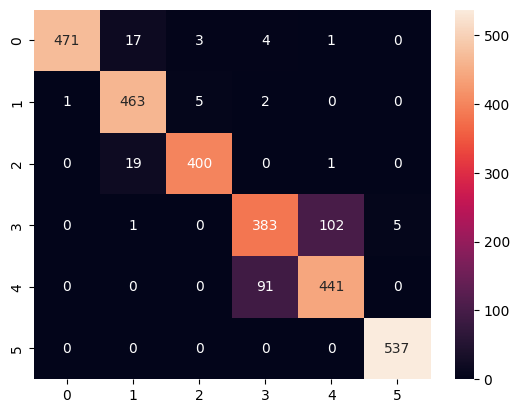

Accuracy: 0.9213


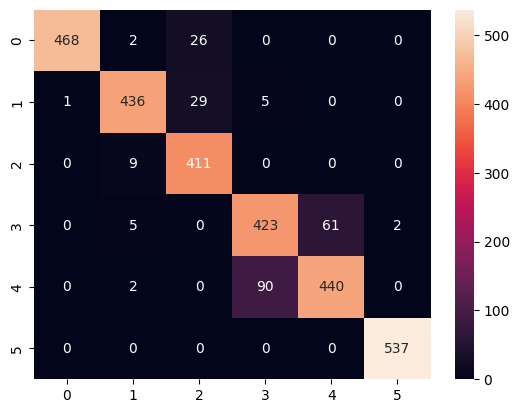

In [14]:
# Evaluating both models
evaluate_model(lstm_model, test_loader)
evaluate_model(cnn_model, test_loader)